<a href="https://colab.research.google.com/github/woaixuexi2023/D2L--Module2--HW1/blob/main/GAN_to_generate_cat_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GAN model to generate cat images

In [8]:
#Use mountain drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
#Navigate the direction where the file located
%cd /content/drive/MyDrive/Cats/cats

/content/drive/MyDrive/Cats/cats


In [10]:
#check the file 
!ls

CAT_00	CAT_01	CAT_02	CAT_03	CAT_04	CAT_05	CAT_06


In [ ]:
##Open zip file
#import zipfile
#import io
#from PIL import Image

##open the zip file
#with zipfile.ZipFile('CATS.zip', 'r') as zip_ref:
#    # loop through all the files in the zip file
#    for file_name in zip_ref.namelist():
#        # check if the file is an image file
#        if file_name.endswith('.jpg') or file_name.endswith('.png'):
#            # extract the image file from the zip file into memory
#            with io.BytesIO(zip_ref.read(file_name)) as image_file:
#                # create a PIL Image object from the extracted image file
#                image = Image.open(image_file)



In [11]:
#Import
import random
import math
import time
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms

In [12]:
#create path directory
INPUT_PATH = "../cats/CAT_00"
img_path_list = glob.glob(os.path.join(INPUT_PATH,"*.jpg"))
print(len(img_path_list))#1760 images

1706


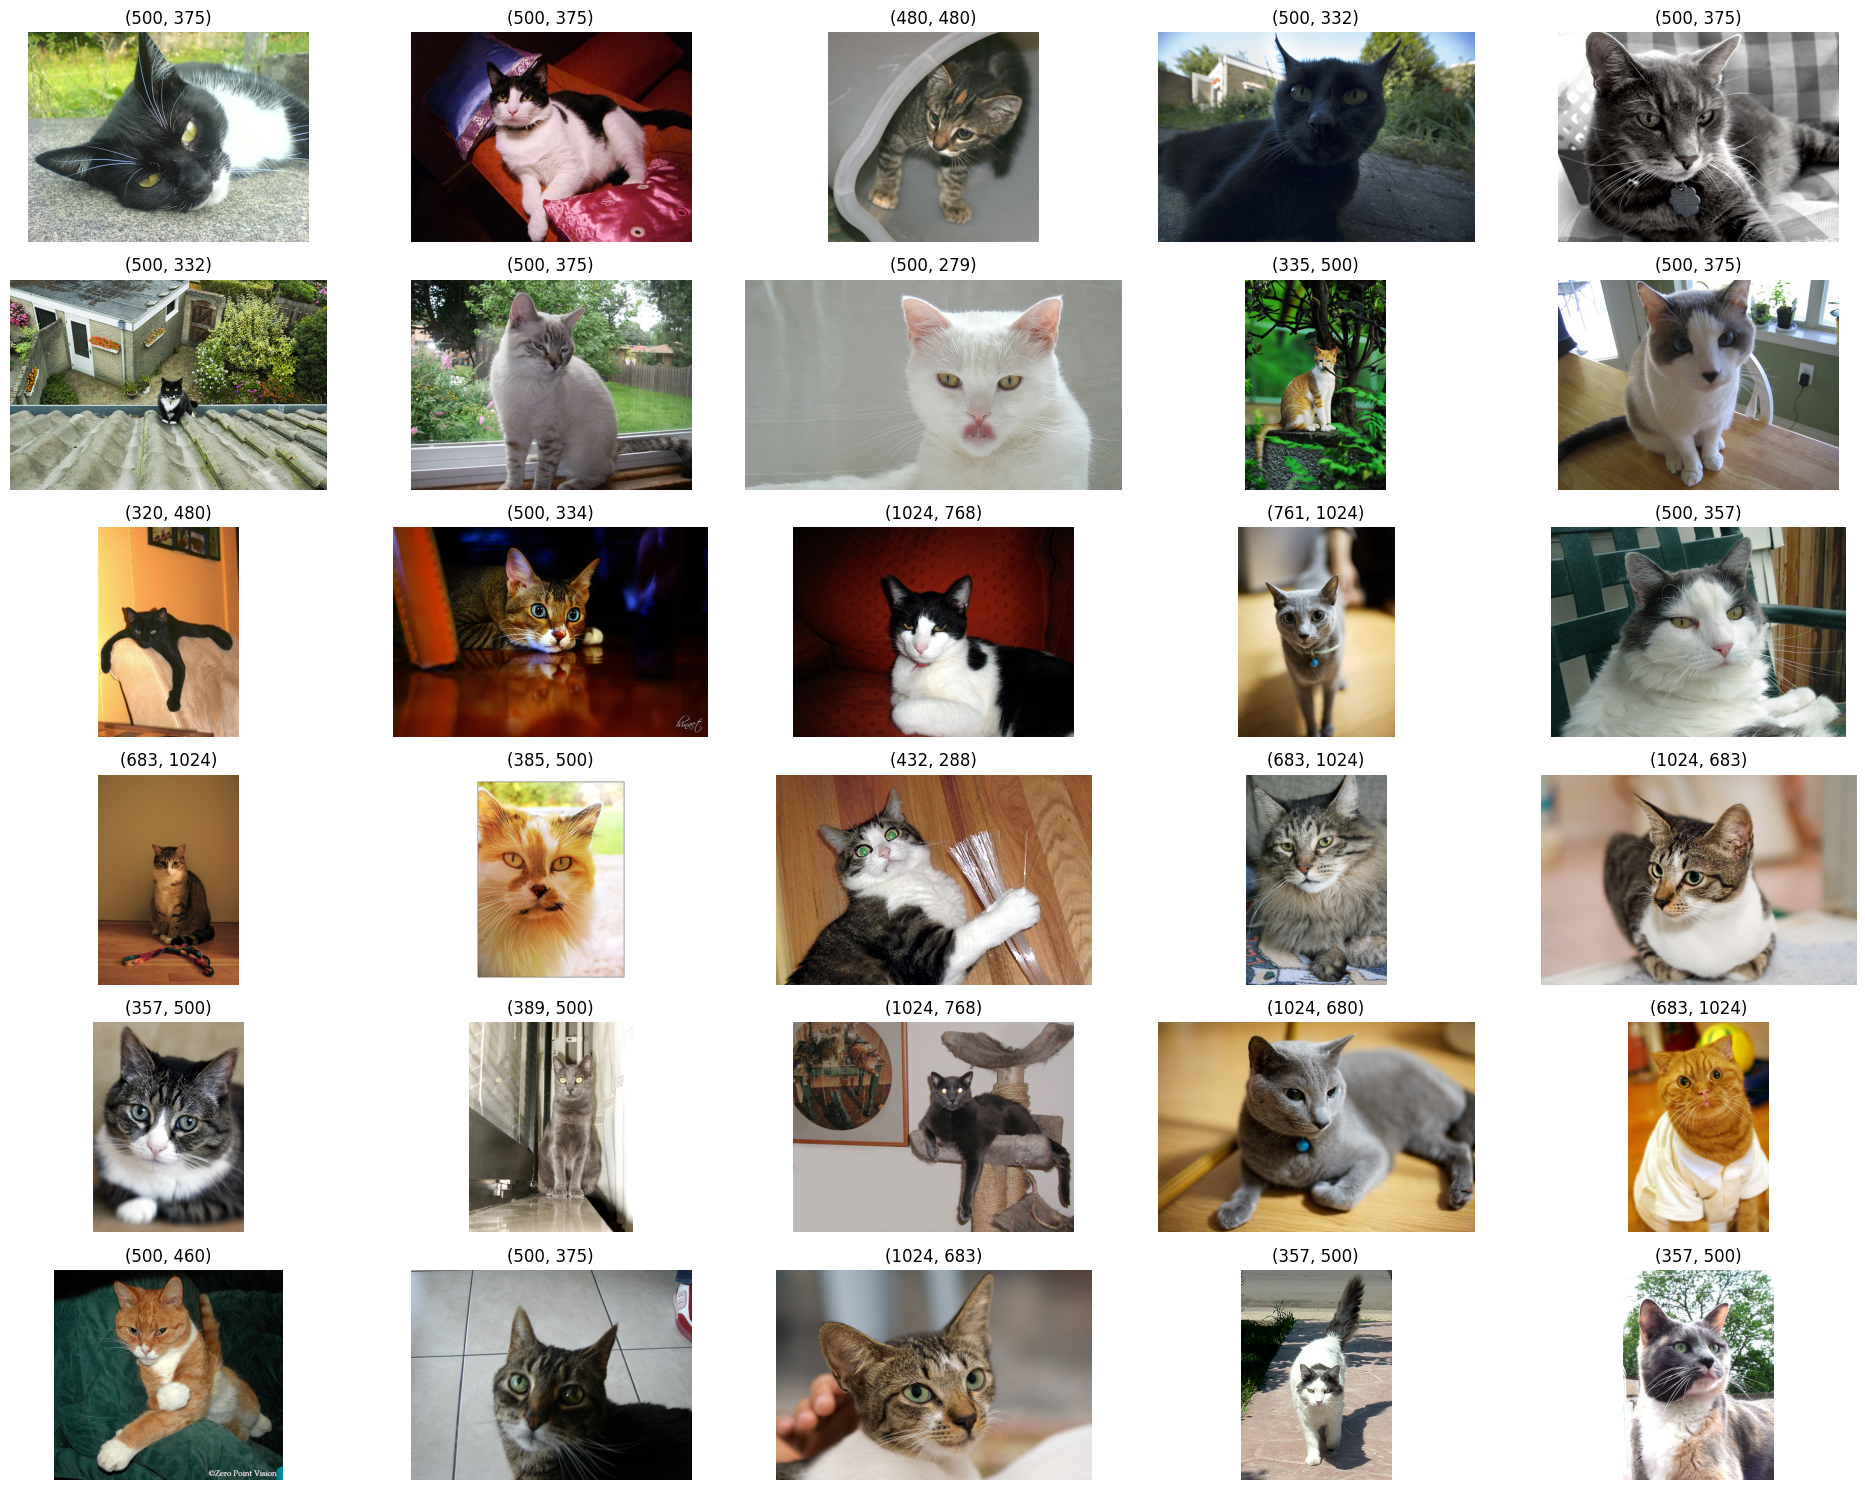

In [7]:
#Display original 30 images
plt.figure(figsize=(20,15),tight_layout = True)
for i in range(30):
    plt.subplot(6,5,i+1)
    img = Image.open(img_path_list[i])
    plt.imshow(img)
    plt.axis("OFF")
    plt.title(img.size)

In [ ]:
``#Skip this cell
#dataloader
def make_img_path_list(use_dir_num):
    train_img_list = []
    for i in range(min(use_dir_num, 8)):
        use_dir = f"../cats/CAT_{i:02d}"
        paths = glob.glob(os.path.join(use_dir,"*.jpg"))
        train_img_list+=paths
        print("num_img",len(train_img_list))
    return train_img_list

train_img_list = make_img_path_list(7)
#train_img_list = make_img_path_list(2)
#train_img_list = make_img_path_list(20)

In [ ]:
```#skip this cell
# transform 
IMG_MEAN = [0.5, 0.5, 0.5]
IMG_STD = [0.5, 0.5, 0.5]
size = (64,64)

data_transform = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(), 
    transforms.Normalize(mean=IMG_MEAN, std=IMG_STD),
])

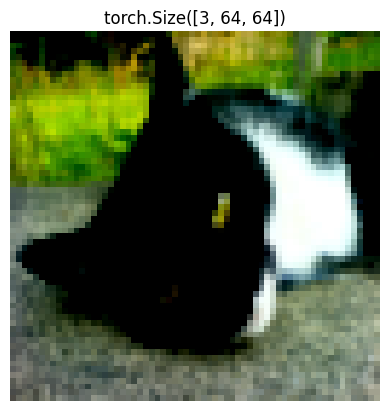

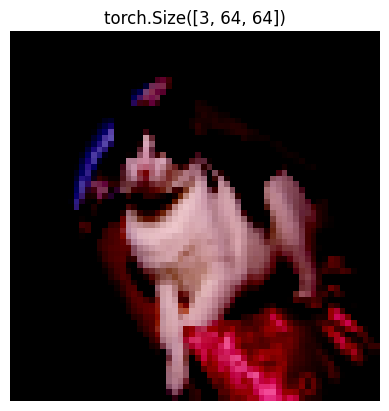

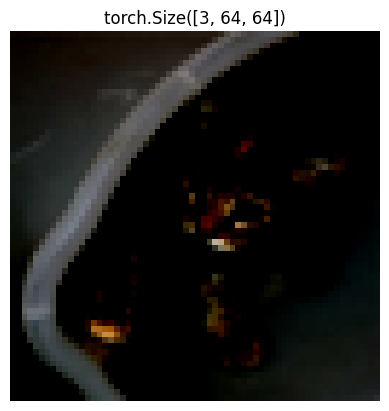

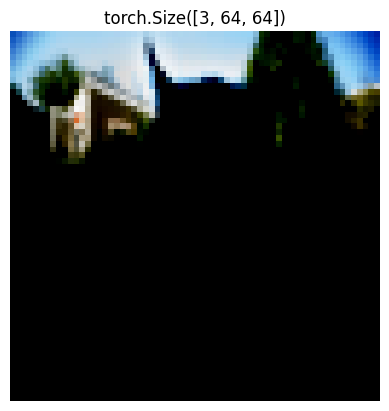

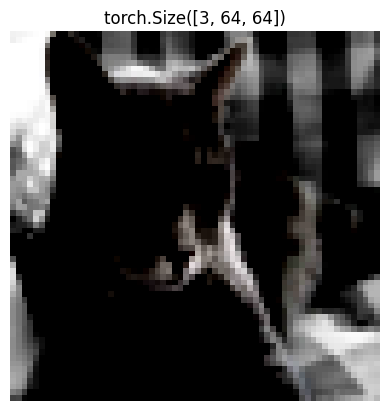

In [ ]:
````#skip this cell
#Visulize the image after transform
for i in range(5):
    img = Image.open(img_path_list[i])
    x = data_transform(img)
    plt.title(x.shape)
    plt.imshow(x.permute(1,2,0))
    plt.axis("off")
    plt.show()

In [15]:
#Normalize data/Transform/
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
dir = "../cats"

train_ds = ImageFolder(dir, transform=tt.Compose([ tt.Resize(image_size),
                                                        tt.CenterCrop(image_size),
                                                        tt.ToTensor(),
                                                        tt.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)                    


In [14]:
```#skip this cell
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# Define the path to the directory containing the images
data_path = '../cats'

# Define the transformation pipeline for the image data
transform = transforms.Compose([
    transforms.Resize(64),          # Resize the image to 64x64 pixels
    transforms.CenterCrop(64),      # Crop the image to 64x64 pixels at the center
    transforms.ToTensor(),          # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image data
])

# Create the ImageFolder dataset object
dataset = datasets.ImageFolder(data_path, transform=transform)

# Create a data loader to load the data in batches
batch_size = 128
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [16]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [17]:
from torchvision.utils import make_grid

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

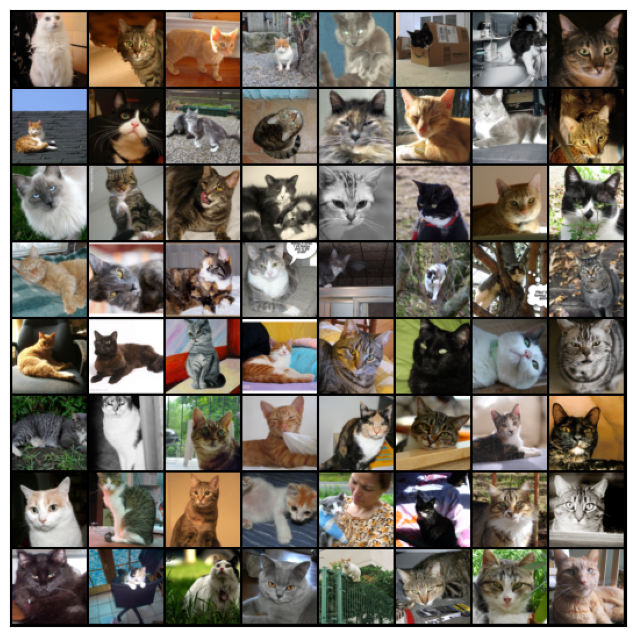

In [18]:
show_batch(train_dl)#64 images from 128 images in one of the batch

In [19]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [20]:
#Generator Model
latent_size = 128
image_size = 64

class Generator(nn.Module):
    def __init__(self, latent_size=128, image_size=64, out_channels=3):
        super(Generator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(latent_size, image_size*8, kernel_size=4, stride=1),
            nn.BatchNorm2d(image_size*8),
            nn.ReLU(inplace=True))

        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(image_size*8, image_size*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size*4),
            nn.ReLU(inplace=True))

        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(image_size*4, image_size*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size*2),
            nn.ReLU(inplace=True))

        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(image_size*2, image_size, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True))

        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, out_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh())

    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)
        return out


fake_img_shape:torch.Size([1, 3, 64, 64])


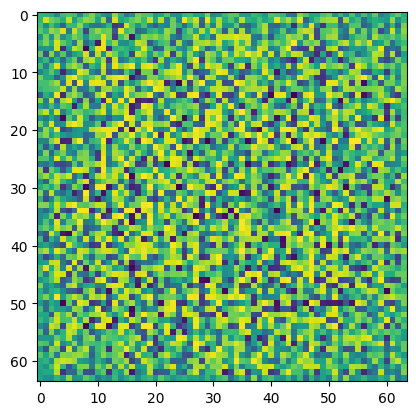

In [21]:
G = Generator(latent_size=128, image_size = 64)

input_z = torch.randn(1,128)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1,1)

# output
fake_images = G(input_z)
print(f"fake_img_shape:{fake_images.shape}")

#
img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed)
plt.show()

In [22]:
# Pass the model to the chosen device.
G.to(device);

In [23]:
#Discriminator model

class Discriminator(nn.Module):
    def __init__(self,image_size = 64):
        super(Discriminator, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, # color image
                      image_size,
                      kernel_size = 4,
                      stride = 2,
                      padding = 1
                     ),
            nn.LeakyReLU(0.1, inplace = True))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(image_size, 
                      image_size*2,
                      kernel_size = 4,
                      stride = 2,
                      padding = 1
                     ),
            nn.LeakyReLU(0.1, inplace = True))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(image_size*2, 
                      image_size*4,
                      kernel_size = 4,
                      stride = 2,
                      padding = 1
                     ),
            nn.LeakyReLU(0.1, inplace = True))

        self.layer4 = nn.Sequential(
            nn.Conv2d(image_size*4, 
                      image_size*8,
                      kernel_size = 4,
                      stride = 2,
                      padding = 1
                     ),
            nn.LeakyReLU(0.1, inplace = True))
        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)
        return out      

In [24]:
# create generator and move to device
G = Generator(image_size=64, latent_size=128).to(device)

# create discriminator and move to device
D = Discriminator(image_size=64).to(device)

# create fake image
input_z = torch.randn(1, 128).to(device)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)

# pass fake image to discriminator
d_out = D(fake_images)

# print output
print(nn.Sigmoid()(d_out))


tensor([[[[0.4975]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [25]:
#define weight
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [26]:
def train_model(G, D, train_dl, num_epochs, device):
    # set optimizers and loss function
    criterion = nn.BCELoss()
    g_optimizer = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
    d_optimizer = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

    G = G.to(device)
    D = D.to(device)
    G.train()
    D.train()

    # create lists to store generator and discriminator losses
    G_losses = []
    D_losses = []

    # create fixed noise vector to visualize the progression of the generator
    fixed_noise = torch.randn(68, 128, 1, 1, device=device)

    for epoch in range(num_epochs):
        print('-------------')
        print(f'Epoch {epoch}/{num_epochs}')
        print('-------------')
        # train
        g_loss_total = 0.0
        d_loss_total = 0.0
        g_cnt = 0
        d_cnt = 0
        for images in train_dl:
            for img in images:
                if img.size()[0] == 1:
                    continue
                img = img.to(device)
                b_size = img.size(0)

                # train discriminator
                d_optimizer.zero_grad()
                real_labels = torch.ones(b_size, device=device)
                fake_labels = torch.zeros(b_size, device=device)
                real_outputs = D(img).view(-1)
                real_loss = criterion(real_outputs, real_labels)
                real_loss.backward()
                D_x = real_outputs.mean().item()

                noise = torch.randn(b_size, 128, 1, 1, device=device)
                fake_images = G(noise)
                fake_outputs = D(fake_images.detach()).view(-1)
                fake_loss = criterion(fake_outputs, fake_labels)
                fake_loss.backward()
                D_G_z1 = fake_outputs.mean().item()

                d_loss = real_loss + fake_loss
                d_optimizer.step()

                # train generator
                g_optimizer.zero_grad()
                labels = torch.ones(b_size, device=device)
                outputs = D(fake_images).view(-1)
                g_loss = criterion(outputs, labels)
                g_loss.backward()
                D_G_z2 = outputs.mean().item()
                g_optimizer.step()

                # accumulate losses and counts
                g_loss_total += g_loss.item() * b_size
                d_loss_total += d_loss.item() * b_size
                g_cnt += b_size
                d_cnt += b_size

        # calculate and print losses for the epoch
        G_loss = g_loss_total / g_cnt
        D_loss = d_loss_total / d_cnt
        print(f'G_loss: {G_loss:.4f}\tD_loss: {D_loss:.4f}')

        # save losses for plotting
        G_losses.append(G_loss)
        D_losses.append(D_loss)

        # visualize generator progress
        G.eval()
        with torch.no_grad():
            fake_images = G(fixed_noise)
        G.train()

    return G_losses, D_losses


In [27]:
#Create a directory
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)#have the samples saved

In [28]:
#train the model
num_epochs = 50
G = Generator(latent_size = 128, image_size = 64)
D = Discriminator(image_size=64)

G.apply(weights_init)
D.apply(weights_init)
print("初始化完成")

G_update, D_update = train_model(
    G, D, train_dl=train_dl, num_epochs=num_epochs, device = device)

初始化完成
-------------
Epoch 0/50
-------------


RuntimeError: ignored

In [ ]:
``#try to fix the error, while it does not work
import os
os.environ['TORCH_USE_CUDA_DSA'] = '1'

G_losses, D_losses = train_model(G, D, train_dl, num_epochs=10, device=device)

In [ ]:
``#skip this cell
device=is_cuda_available()
train_dl = DeviceDataLoader(train_dl, device)